### 유튜브 영상 댓글 크롤링 ver2

🎬 추출된 video_id 목록: ['lxZsn3cwdAU']

📥 lxZsn3cwdAU 댓글 전체 수집 시작
✅ lxZsn3cwdAU - 1 페이지 수집 완료, 누적 댓글 수: 100
✅ lxZsn3cwdAU - 2 페이지 수집 완료, 누적 댓글 수: 200
✅ lxZsn3cwdAU - 3 페이지 수집 완료, 누적 댓글 수: 300
✅ lxZsn3cwdAU - 4 페이지 수집 완료, 누적 댓글 수: 396
💾 (실시간 저장) 동영상 lxZsn3cwdAU 댓글 CSV 저장 완료: youtube_results/comments_lxZsn3cwdAU.csv

📊 수집된 댓글 데이터프레임 미리보기:
      video_id                  comment_id           author  \
0  lxZsn3cwdAU  Ugy2KO2jf77Ua_Qhl-Z4AaABAg   @OneshotHansol   
1  lxZsn3cwdAU  UgxAECbf4JoJrrHxJ2h4AaABAg           @연세보청기   
2  lxZsn3cwdAU  Ugx6xaclcJ2HLwEYfsl4AaABAg  @Nyaaaaaaaaammm   
3  lxZsn3cwdAU  UgybRrXvceG12UxHk4B4AaABAg      @Mcxxoxm273   
4  lxZsn3cwdAU  Ugz9HuSnraUKStDbhu94AaABAg     @boywithgame   

                                                text  likeCount  \
0          본영상 보러가기😀👇🏻\nhttps://youtu.be/xOL-LCw0kfg        897   
1  이게 단순히 소리가 들린다가 아니라, 어떻게 들리느냐가 문제였군요…\r 들을 수 있...          0   
2  친구중에 인공와우를 어릴때부터 사용한 친구가 있는데 모든 사람에게 이렇게 들릴까요?...          0   
3                 

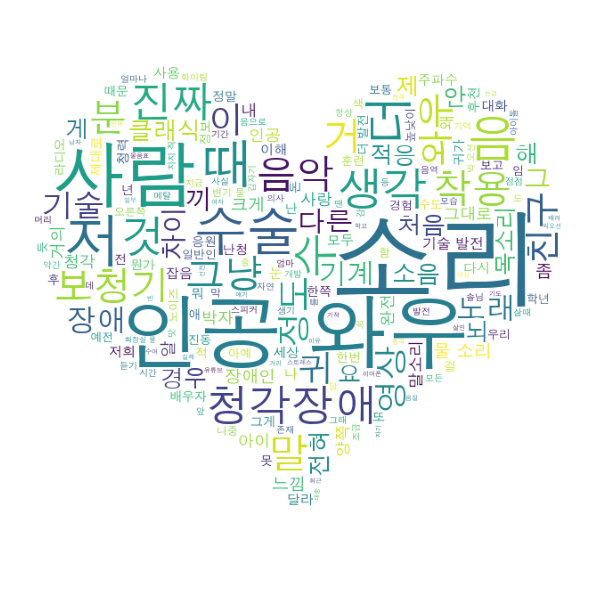

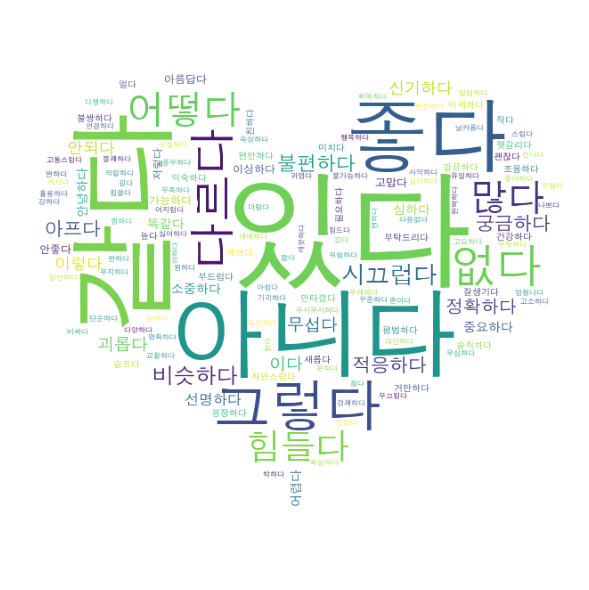

In [ ]:
import requests
import pandas as pd
from time import sleep
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np  
from konlpy.tag import Okt 
import os
import re


# ================================
# 0) API 키 & 수집할 URL 설정
# ================================
API_KEY = "api 키 입력"

urls = [
    "https://www.youtube.com/shorts/lxZsn3cwdAU",
    # "https://www.youtube.com/watch?v=dFRXcYJVfMM",
]

# 결과 저장 폴더 설정
RESULT_DIR = "youtube_results"
os.makedirs(RESULT_DIR, exist_ok=True)


# ================================
# 1) URL에서 video_id 추출 함수
# ================================
def extract_video_id(url: str):
    """
    유튜브 일반 영상 & 쇼츠 URL에서 video_id만 뽑아주는 함수
    """
    # 쿼리파라미터(?) 제거용
    base = url.split("?")[0]

    # shorts 형식: https://www.youtube.com/shorts/VIDEO_ID
    if "shorts/" in base:
        return base.split("shorts/")[1]

    # 일반 영상 형식: https://www.youtube.com/watch?v=VIDEO_ID
    if "watch" in base and "v=" in url:
        return url.split("v=")[1].split("&")[0]

    return None


# ================================
# 2) 특정 video_id 전체 댓글 수집
# ================================
def fetch_all_comments_for_video(video_id: str, sleep_sec: float = 0.2):
    """
    특정 video_id에 대한 상위 댓글(Top-level comments)을
    마지막 페이지까지 전부 수집하는 함수
    """
    url = "https://www.googleapis.com/youtube/v3/commentThreads"
    params = {
        "part": "snippet",
        "videoId": video_id,
        "maxResults": 100,           # 한 페이지 최대 100개
        "textFormat": "plainText",
        "key": API_KEY,
    }

    comments = []
    next_page_token = None
    page_idx = 0

    while True:
        if next_page_token:
            params["pageToken"] = next_page_token

        res = requests.get(url, params=params)
        data = res.json()

        # 에러 발생 시 출력하고 중단
        if "error" in data:
            print(f"⚠️ API Error for video {video_id}: ", data["error"])
            break

        items = data.get("items", [])
        if not items:
            break

        for item in items:
            snippet = item["snippet"]["topLevelComment"]["snippet"]
            comments.append({
                "video_id": video_id,
                "comment_id": item["id"],
                "author": snippet.get("authorDisplayName"),
                "text": snippet.get("textDisplay"),
                "likeCount": snippet.get("likeCount"),
                "publishedAt": snippet.get("publishedAt"),
            })

        page_idx += 1
        print(f"✅ {video_id} - {page_idx} 페이지 수집 완료, 누적 댓글 수: {len(comments)}")

        # 다음 페이지 토큰 확인
        next_page_token = data.get("nextPageToken")
        if not next_page_token:
            break

        sleep(sleep_sec)  # API 호출 간 살짝 쉬어주기 (쿼터/차단 방지)

    return comments


# ================================
# 3) 모든 URL에 대해 댓글 수집
# ================================
def collect_comments_from_urls(url_list):
    video_ids = [extract_video_id(u) for u in url_list]
    print("🎬 추출된 video_id 목록:", video_ids)

    all_comments = []
    for vid in video_ids:
        if vid is None:
            print(f"⚠️ URL에서 video_id를 추출하지 못했습니다. 건너뜀.")
            continue

        print(f"\n📥 {vid} 댓글 전체 수집 시작")
        video_comments = fetch_all_comments_for_video(vid)

        # 1) 이 영상의 댓글을 바로 CSV로 저장
        if video_comments:
            df_vid = pd.DataFrame(video_comments)
            filename = f"comments_{vid}.csv"
            path = os.path.join(RESULT_DIR, filename)
            df_vid.to_csv(path, index=False, encoding="utf-8-sig")
            print(f"💾 (실시간 저장) 동영상 {vid} 댓글 CSV 저장 완료: {path}")
        else:
            print(f"⚠️ 동영상 {vid} 에는 댓글이 없습니다.")

        
        all_comments.extend(video_comments)

    df = pd.DataFrame(all_comments)
    return df


# ================================
# 4) CSV & PKL 저장
# ================================
def save_comments(df: pd.DataFrame,
                  csv_name="youtube_comments_all.csv",
                  pkl_name="youtube_comments_all.pkl"):
    csv_path = os.path.join(RESULT_DIR, csv_name)
    pkl_path = os.path.join(RESULT_DIR, pkl_name)

    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    df.to_pickle(pkl_path)

    print(f"💾 CSV 저장 완료: {csv_path}")
    print(f"💾 PKL 저장 완료: {pkl_path}")

# ================================
# 4-1) video_id 별로 CSV 따로 저장
# ================================
def save_comments_per_video(df: pd.DataFrame):
    if "video_id" not in df.columns:
        print("⚠️ DataFrame에 'video_id' 컬럼이 없습니다.")
        return

    for vid, sub_df in df.groupby("video_id"):
        filename = f"comments_{vid}.csv"
        path = os.path.join(RESULT_DIR, filename)
        sub_df.to_csv(path, index=False, encoding="utf-8-sig")
        print(f"💾 동영상 {vid} 댓글 CSV 저장 완료: {path}")

        
# ================================
# 4-2) 한국어 형용사만 추출 (전처리 포함)
# ================================
okt = Okt()

def clean_text(text: str) -> str:
    """
    기본 전처리:
    - URL 제거
    - 이모지 제거
    - 특수문자 제거
    - 영어/숫자 제거
    - 중복 공백 정리
    """
    # 1) URL 제거
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # 2) 이모지 제거 (유니코드 상위 영역 날리기)
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)

    # 3) 특수문자 제거 (한글/영문/숫자/공백만 남기기)
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', ' ', text)

    # 4) 영어/숫자 제거 (한국어 위주 분석이면 추천)
    text = re.sub(r'[a-zA-Z0-9]', ' ', text)

    # 5) 중복 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def extract_korean_adjectives(texts):
    """
    한국어 댓글 리스트에서 형용사(Adjective)만 뽑아서
    하나의 큰 문자열로 반환 (전처리 포함)
    """
    adjectives = []

    for t in texts:
        try:
            cleaned = clean_text(t)  # 🔥 전처리 먼저!
            pos_tags = okt.pos(cleaned, norm=True, stem=True)
            for word, tag in pos_tags:
                if tag == "Adjective":
                    adjectives.append(word)
        except Exception as e:
            continue

    return " ".join(adjectives)


def extract_korean_nouns(texts):
    """
    한국어 댓글 리스트에서 명사(Noun)만 추출하여
    하나의 큰 문자열로 반환 (전처리 포함)
    """
    nouns = []

    for t in texts:
        try:
            cleaned = clean_text(t)  # 🔥 전처리 먼저
            pos_tags = okt.pos(cleaned, norm=True, stem=True)
            for word, tag in pos_tags:
                if tag == "Noun":   # ← 여기만 바뀜!
                    nouns.append(word)
        except:
            continue
    
    return " ".join(nouns)




# ================================
# 5) 워드 클라우드 생성
# ================================
def create_wordcloud(df: pd.DataFrame,output_img: str = "youtube_comments_wordcloud.png",mask_path: str | None = None,use_adjectives: bool = True,):
    # 1) 댓글 텍스트 모으기
    texts = df["text"].dropna().astype(str).tolist()
    if not texts:
        print("⚠️ 생성할 텍스트가 없습니다.")
        return

    # # 우선순위: 명사 → 형용사 → 원문
    # if use_nouns:
    #     print("🔎 명사만 추출하여 워드클라우드 생성 중...")
    #     full_text = extract_korean_nouns(texts)
    # elif use_adjectives:
    #     print("🔎 형용사만 추출하여 워드클라우드 생성 중...")
    #     full_text = extract_korean_adjectives(texts
    # if not full_text.strip():
    #     print("⚠️ 추출된 텍스트가 비어 있습니다.")
    #     return

    # 🔹 명사 / 형용사 각각 전처리 및 추출
    print("🔎 명사 추출 중...")
    nouns_text = extract_korean_nouns(texts)

    print("🔎 형용사 추출 중...")
    adjs_text = extract_korean_adjectives(texts)

    # 3) 마스크 적용
    mask = None
    if mask_path is not None and os.path.exists(mask_path):
        mask = np.array(plt.imread(mask_path))
        print(f"🎭 마스크 적용: {mask_path}")
    elif mask_path is not None:
        print(f"⚠️ 마스크 파일을 찾을 수 없습니다: {mask_path} (마스크 없이 생성)")

    # 4) 폰트 경로 설정 (환경 맞게 수정!)
    #   - Mac: '/Library/Fonts/AppleGothic.ttf'
    #   - Win: 'C:/Windows/Fonts/malgun.ttf'
    font_path = "/Library/Fonts/AppleGothic.ttf"

    # =======
    # 1) 명사 워드클라우드 생성
    # ======
    wc_noun = WordCloud(
        font_path=font_path,
        width=1000,
        height=800,
        background_color="white",
        mask=mask
    ).generate(nouns_text)

    noun_img_path = os.path.join(RESULT_DIR, "wordcloud_nouns.png")
    plt.figure(figsize=(10, 6))
    plt.imshow(wc_noun)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(noun_img_path, dpi=300)
    print(f"🖼 명사 워드클라우드 저장 완료: {noun_img_path}")

    # ========
    # 2) 형용사 워드클라우드 생성
    # ========
    wc_adj = WordCloud(
        font_path=font_path,
        width=1000,
        height=800,
        background_color="white",
        mask=mask
    ).generate(adjs_text)

    adj_img_path = os.path.join(RESULT_DIR, "wordcloud_adjectives.png")
    plt.figure(figsize=(10, 6))
    plt.imshow(wc_adj)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(adj_img_path, dpi=300)
    print(f"🖼 형용사 워드클라우드 저장 완료: {adj_img_path}")


# ================================
# 6) 메인 실행부
# ================================
if __name__ == "__main__":
    # 1) 댓글 전체 수집
    df_comments = collect_comments_from_urls(urls)
    print("\n📊 수집된 댓글 데이터프레임 미리보기:")
    print(df_comments.head())

    print("------------csv, pkl, wordclud--------------")
    # 2) CSV / PKL 저장
    save_comments(df_comments)

    # 3) 워드클라우드 생성
    create_wordcloud(
        df_comments,
        mask_path="heart.jpg",  
    )
